In [75]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import scipy.stats as stats
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [76]:
#Import 2015 and 2017 census data, change column names to be consistent across datasets

df2015 = pd.read_csv('acs2015_census_tract_data.csv')

df2017 = pd.read_csv('acs2017_census_tract_data.csv')
df2017.rename({'TractId': 'CensusTract', 'VotingAgeCitizen': 'Citizen'}, axis=1, inplace=True)

In [77]:
#Change count statistics to percentages based on total population; remove %women because of perfect multicollinearity with %men

df2015['Men'] = df2015['Men']/df2015['TotalPop']
df2015['Citizen'] = df2015['Citizen']/df2015['TotalPop']
df2015['Employed'] = df2015['Employed']/df2015['TotalPop']
df2015.drop(['CensusTract', 'Women'], axis=1, inplace=True)

df2017['Men'] = df2017['Men']/df2017['TotalPop']
df2017['Citizen'] = df2017['Citizen']/df2017['TotalPop']
df2017['Employed'] = df2017['Employed']/df2017['TotalPop']
df2017.drop(['CensusTract', 'Women'], axis=1, inplace=True)

In [78]:
#Create df_diff as change from 2015 to 2017
#Add Poverty_Change variable as categorical, -1=significant decrease in poverty, 0=no significant change, +1=significant increase in poverty

df_diff = df2017.copy()
df_diff.drop(['State', 'County'], axis=1, inplace=True)
for col in df_diff:
        df_diff[col] = df2017[col] - df2015[col]
df_diff['Poverty_Change'] = 0
df_diff.loc[(df_diff['Poverty'] >= 1.5), 'Poverty_Change'] = 1
df_diff.loc[(df_diff['Poverty'] <= -1.5), 'Poverty_Change'] = -1

#Add poverty change to 2015 dataset
df2015['Poverty_Change'] = df_diff['Poverty_Change']
df2015['Poverty_Change_val'] = df_diff['Poverty']

df2015['Poverty_Change_2c'] = 0
df2015.loc[(df2015['Poverty_Change_val'] <= -1.5), 'Poverty_Change_2c'] = 1

In [79]:
# #Create PCA components to capture 50% of the variation in 'State' and 'County' variables

# pca = PCA(n_components=33)
# principal_components = pca.fit_transform(pd.concat([pd.get_dummies(df2015['State']), pd.get_dummies(df2015['County'])], axis=1))

# principalDf = pd.DataFrame(data = principal_components)
# df2015 = pd.concat([df2015, principalDf], axis=1)

In [80]:
#Drop null values

df2015.dropna(inplace=True)
df_diff.dropna(inplace=True)

In [81]:
#Winsorize outliers

for col in df2015.columns[2:]:
    threshold = 3
    q75, q25 = np.percentile(df2015[col], [75,25])
    iqr = q75-q25
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)

    outliers = df2015[(df2015[col] > max_val) | (df2015[col] < min_val)]
    print(col)
    print('There are {} tracts identified as outliers.'.format(outliers.shape[0]))

    df2015[col] = pd.Series(winsorize(df2015[col], limits = (outliers.shape[0]/df2015[col].shape[0])))

for col in df_diff.columns:
    threshold = 3
    q75, q25 = np.percentile(df_diff[col], [75,25])
    iqr = q75-q25
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)

    outliers = df_diff[(df_diff[col] > max_val) | (df_diff[col] < min_val)]
    print(col)
    print('There are {} tracts identified as outliers.'.format(outliers.shape[0]))

    df_diff[col] = pd.Series(winsorize(df_diff[col], limits = (outliers.shape[0]/df_diff[col].shape[0])))

TotalPop
There are 298 tracts identified as outliers.
Men
There are 539 tracts identified as outliers.
Hispanic
There are 3487 tracts identified as outliers.
White
There are 0 tracts identified as outliers.
Black
There are 5369 tracts identified as outliers.
Native
There are 5031 tracts identified as outliers.
Asian
There are 4158 tracts identified as outliers.
Pacific
There are 8847 tracts identified as outliers.
Citizen
There are 431 tracts identified as outliers.
Income
There are 437 tracts identified as outliers.
IncomeErr
There are 846 tracts identified as outliers.
IncomePerCap
There are 992 tracts identified as outliers.
IncomePerCapErr
There are 1893 tracts identified as outliers.
Poverty
There are 169 tracts identified as outliers.
ChildPoverty
There are 0 tracts identified as outliers.
Professional
There are 0 tracts identified as outliers.
Service
There are 82 tracts identified as outliers.
Office
There are 25 tracts identified as outliers.
Construction
There are 230 tracts 

In [82]:
#Drop null values

df2015.dropna(inplace=True)
df_diff.dropna(inplace=True)

In [83]:
#Create y-variable as categorical poverty change, X variable as all 2015 statistics
#Perform train test split; also create "small" dataset for faster computation during testing
#Create scaled dataset for use when necessary

y = df2015['Poverty_Change_2c']

X = df2015.drop(['State', 'County', 'Poverty_Change', 'Poverty_Change_val', 'Poverty_Change_2c'], axis=1)

df_small = df2015.sample(frac=0.1)
y_small = df_small['Poverty_Change_2c']
X_small = df_small.drop(['State', 'County', 'Poverty_Change', 'Poverty_Change_val', 'Poverty_Change_2c'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_small,y_small,test_size=0.2)

scaler = StandardScaler()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scale = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_train_s_scale = pd.DataFrame(scaler.fit_transform(X_train_s), columns = X_train_s.columns)
X_test_s_scale = pd.DataFrame(scaler.fit_transform(X_test_s), columns = X_test_s.columns)

In [88]:
sm = SMOTE()
rus = RandomUnderSampler(sampling_strategy=0.5)

#X_train_re, y_train_re = rus.fit_resample(X_train, y_train)
#X_train_res, y_train_res = sm.fit_resample(X_train_re, y_train_re)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [39]:
X_train_re_scale, y_train_re_scale = rus.fit_resample(X_train_scale, y_train)
X_train_res_scale, y_train_res_scale = sm.fit_resample(X_train_re_scale, y_train_re_scale)

In [40]:
# #Perform same train test split for numerical poverty change variable for regression testing

# y2 = df2015['Poverty_Change_val']

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y2,test_size=0.2)

# scaler = StandardScaler()
# X_train_scale2 = pd.DataFrame(scaler.fit_transform(X_train2), columns = X_train2.columns)
# X_test_scale2 = pd.DataFrame(scaler.fit_transform(X_test2), columns = X_test2.columns)

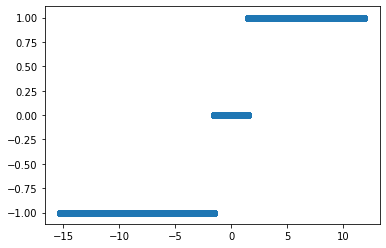

In [54]:
plt.scatter(df2015['Poverty_Change_val'], df2015['Poverty_Change'])

(array([27717.,     0.,     0.,     0.,     0., 25815.,     0.,     0.,
            0., 17991.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

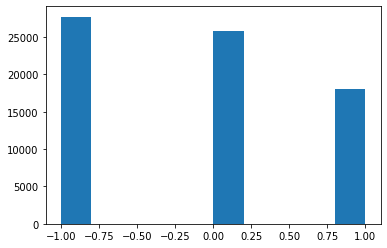

In [55]:
plt.hist(df2015['Poverty_Change'])

In [41]:
#Perform dummy classification for baseline

dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train_res, y_train_res)

print(dummy.score(X_train, y_train))
print(dummy.score(X_test, y_test))

0.7495892900835401
0.7439356868227892


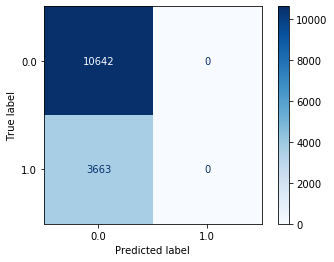

In [42]:
plot_confusion_matrix(dummy, X_test, y_test, cmap='Blues')

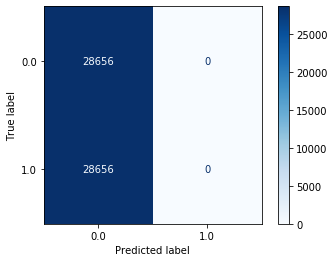

In [43]:
plot_confusion_matrix(dummy, X_train_res, y_train_res, cmap='Blues')

In [93]:
start_time = time.time()

logit = LogisticRegression(max_iter=10000)

logit.fit(X_train, y_train)
print(logit.score(X_train, y_train))
print(logit.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

0.6590059072319899
0.6597693114295701
--- 0.7392091751098633 seconds ---


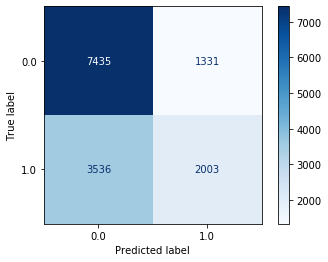

In [94]:
plot_confusion_matrix(logit, X_test, y_test, cmap='Blues')

In [95]:
start_time = time.time()

logit_smote = LogisticRegression(max_iter=10000)

logit_smote.fit(X_train_res, y_train_res)
print(logit_smote.score(X_train, y_train))
print(logit_smote.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

0.6626586039358244
0.6613072352324362
--- 1.8814456462860107 seconds ---


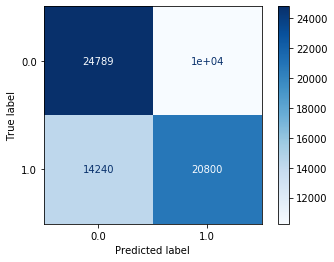

In [96]:
plot_confusion_matrix(logit_smote, X_train_res, y_train_res, cmap='Blues')

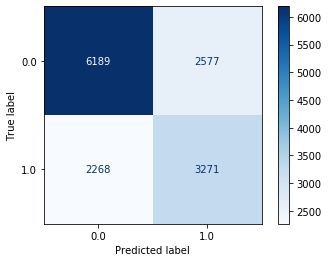

In [97]:
plot_confusion_matrix(logit_smote, X_test, y_test, cmap='Blues')

In [62]:
# start_time = time.time()

# forest_c = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=1000)

# forest_c.fit(X_train, y_train)

# print(forest_c.score(X_train, y_train))
# print(forest_c.score(X_test, y_test))

# print("--- %s seconds ---" % (time.time() - start_time))

In [63]:
# plot_confusion_matrix(forest_c, X_test, y_test, cmap='Blues')

In [17]:
# start_time = time.time()

# svm_c_lin = SVC(kernel='linear', C=1)

# svm_c_lin.fit(X_train_s_scale, y_train_s)

# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()

# print(svm_c_lin.score(X_train_s_scale, y_train_s))
# print(svm_c_lin.score(X_test_s_scale, y_test_s))

# print("--- %s seconds ---" % (time.time() - start_time))

In [18]:
# plot_confusion_matrix(svm_c_lin, X_test_s_scale, y_test_s, cmap='Blues')

In [19]:
# start_time = time.time()

# svm_c_rbf = SVC(kernel='rbf', C=0.2)

# svm_c_rbf.fit(X_train_s_scale, y_train_s)

# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()

# print(svm_c_rbf.score(X_train_s_scale, y_train_s))
# print(svm_c_rbf.score(X_test_s_scale, y_test_s))

# print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# plot_confusion_matrix(svm_c_rbf, X_test_s_scale, y_test_s, cmap='Blues')

In [18]:
start_time = time.time()

boost_c = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=2, subsample=0.5, max_features='sqrt')

boost_c.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

print(boost_c.score(X_train, y_train))
print(boost_c.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

--- 35.52397131919861 seconds ---
0.7557936313747422
0.752394267738553
--- 1.2776165008544922 seconds ---


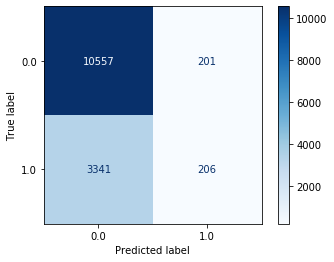

In [19]:
plot_confusion_matrix(boost_c, X_test, y_test, cmap='Blues')

In [20]:
start_time = time.time()

boost_c_smote = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=2, subsample=0.5, max_features='sqrt')

boost_c_smote.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

print(boost_c_smote.score(X_train, y_train))
print(boost_c_smote.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

--- 43.98436093330383 seconds ---
0.7335803418504666
0.7224047535826634
--- 1.3005383014678955 seconds ---


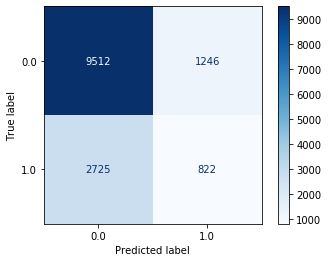

In [21]:
plot_confusion_matrix(boost_c_smote, X_test, y_test, cmap='Blues')

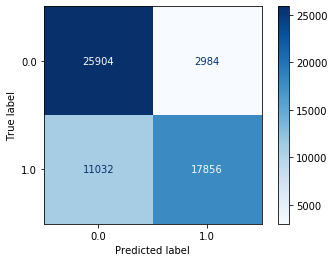

In [22]:
plot_confusion_matrix(boost_c_smote, X_train_res, y_train_res, cmap='Blues')

In [23]:
# start_time = time.time()

# xboost_c = XGBClassifier(n_estimators=1000, max_depth=2, subsample=0.5, eta=0.1, colsample_bytree=0.7, objective='multi:softmax', num_class=3)

# xboost_c.fit(X_train_scale, y_train)

# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()

# print(xboost_c.score(X_train_scale, y_train))
# print(xboost_c.score(X_test_scale, y_test))

# print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
# plot_confusion_matrix(xboost_c, X_test_scale, y_test, cmap='Blues')

_________________________________________________________________________________________________

In [28]:
# #Perform dummy regression on numerical variable for baseline

# dummyReg2 = DummyRegressor(strategy = 'mean')
# dummyReg2.fit(X_train2, y_train2)

# dummy_pred = dummyReg2.predict(X_test2)

# print(dummyReg.score(X_train2, y_train2))
# print(dummyReg.score(X_test2, y_test2))

In [29]:
# dummy_error = dummy_pred - y_test2

# plt.scatter(y_test2, dummy_error)

# x = np.linspace(-20,25,100)
# y = -1*x
# plt.plot(x, y, '-r')

In [30]:
# plt.hist(dummy_pred)
# plt.show()

In [31]:
# start_time = time.time()

# boost_r2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, max_depth=2, subsample=0.5, max_features='sqrt')

# boost_r2.fit(X_train_scale2, y_train2)

# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()

# print(boost_r2.score(X_train_scale2, y_train2))
# print(boost_r2.score(X_test_scale2, y_test2))

# boost_pred_train = boost_r2.predict(X_train_scale2)
# boost_pred = boost_r2.predict(X_test_scale2)

# print("--- %s seconds ---" % (time.time() - start_time))

In [32]:
# boost_error = boost_pred - y_test2
# train_boost_error = boost_pred_train - y_train2

# plt.scatter(y_test2, boost_error)
# x = np.linspace(-20,25,100)
# y = -1*x
# plt.plot(x, y, '-r')
# plt.show()
# plt.scatter(y_train2, train_boost_error)
# x = np.linspace(-20,25,100)
# y = -1*x
# plt.plot(x, y, '-r')
# plt.show()

In [33]:
# plt.hist(boost_pred, bins=200)
# plt.show()
# plt.hist(boost_pred_train, bins=200)
# plt.show()

In [34]:
# start_time = time.time()

# xboost_r2 = XGBRegressor(n_estimators=1000, max_depth=3, subsample=0.7, eta=0.1, colsample_bytree=0.7)

# xboost_r2.fit(X_train_scale2, y_train2)

# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()

# print(xboost_r2.score(X_train_scale2, y_train2))
# print(xboost_r2.score(X_test_scale2, y_test2))

# xboost_pred_train = xboost_r2.predict(X_train_scale2)
# xboost_pred = xboost_r2.predict(X_test_scale2)

# print("--- %s seconds ---" % (time.time() - start_time))

In [35]:
# xboost_error = xboost_pred - y_test2
# train_xboost_error = xboost_pred_train - y_train2

# plt.scatter(y_test2, xboost_error)
# x = np.linspace(-20,25,100)
# y = -1*x
# plt.plot(x, y, '-r')
# plt.show()
# plt.scatter(y_train2, train_xboost_error)
# x = np.linspace(-20,25,100)
# y = -1*x
# plt.plot(x, y, '-r')
# plt.show()

In [36]:
# plt.hist(xboost_pred, bins=200)
# plt.show()
# plt.hist(xboost_pred_train, bins=200)
# plt.show()